## Task 3: Feature Engineering & Modelling
<font size="3"> **Background information**
    
<font size="3">The team now has a good understanding of the data and feels confident to use the data to further understand the business problem. The team now needs to brainstorm and build out features to uncover signals in the data that could inform the churn model.

<font size="3">Feature engineering is one of the keys to unlocking predictive insight through mathematical modeling. Based on the data that is available and was cleaned, identify what you think could be drivers of churn for our client and build those features to later use in your model.

<font size="3">First focus on building on top of the feature that your colleague has already investigated: “the difference between off-peak prices in December and January the preceding year”. After this, if you have time, feel free to get creative with making any other features that you feel are worthwhile.

<font size="3">Once you have a set of features, you must train a Random Forest classifier to predict customer churn and evaluate the performance of the model with suitable evaluation metrics. Be rigorous with your approach and give full justification for any decisions made by yourself as the intern data scientist. 

<font size="3">Recall that the hypotheses under consideration is that churn is driven by the customers’ price sensitivities and that it would be possible to predict customers likely to churn using a predictive model.

<font size="3">If you’re eager to go the extra mile for the client, when you have a trained predictive model, remember to investigate the client’s proposed discounting strategy, with the head of the SME division suggesting that offering customers at high propensity to churn a 20% discount might be effective.

<font size="3">Build your models and test them while keeping in mind you would need data to prove/disprove the hypotheses, as well as to test the effect of a 20% discount on customers at high propensity to churn.
    
<font size="3"> **Task**
    
<font size="3">Sub-Task 1

<font size="3">Your colleague has done some work on engineering the features within the cleaned dataset and has calculated a feature which seems to have predictive power. 

<font size="3">This feature is “the difference between off-peak prices in December and January the preceding year”. 

<font size="3">Run the cells in the notebook provided (named feature_engineering.ipynb) to re-create this feature. then try to think of ways to improve the feature’s predictive power and elaborate why you made those choices. 

<font size="3">Sub-Task 2

<font size="3">Now that you have a dataset of cleaned and engineered features, it is time to build a predictive model to see how well these features are able to predict a customer churning. It is your task to train a Random Forest classifier and to evaluate the results in an appropriate manner. We would also like you to document the advantages and disadvantages of using a Random Forest for this use case. 

In [82]:
# load packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

### Sub-Task 1

<font size="3"> Prepare date

In [83]:
# drop useless columns
train_data = client.copy()
train_data['year_modif_prod'] = train_data['date_modif_prod'].dt.year
train_data['year_renewal'] = train_data['date_renewal'].dt.year
train_data = train_data.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'])
# 
has_gas_encoder = LabelEncoder()
train_data['has_gas'] = has_gas_encoder.fit_transform(train_data['has_gas'])
# add new feature "diff_dec_jan_off_peak_var" and "diff_dec_jan_off_peak_fix". I just calculate the differnece between last price and first price for each customer.
# diff_dec_jan_off_peak_var = price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(-1) - price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].nth(0)
# diff_dec_jan_off_peak_var = diff_dec_jan_off_peak_var.reset_index(name='diff_dec_jan_off_peak_var')
# Calculate the difference between the last and first prices for each customer for off-peak variable prices
diff_dec_jan_off_peak_var = price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].last() - price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_var'].first()
diff_dec_jan_off_peak_var = diff_dec_jan_off_peak_var.reset_index(name='diff_dec_jan_off_peak_var')


# diff_dec_jan_off_peak_fix = price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(-1) - price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].nth(0)
# diff_dec_jan_off_peak_fix = diff_dec_jan_off_peak_fix.reset_index(name='diff_dec_jan_off_peak_fix')


# Calculate the difference between the last and first prices for each customer for off-peak fixed prices
diff_dec_jan_off_peak_fix = price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].last() - price.sort_values(by=['price_date']).groupby(['id'])['price_off_peak_fix'].first()
diff_dec_jan_off_peak_fix = diff_dec_jan_off_peak_fix.reset_index(name='diff_dec_jan_off_peak_fix')

diff_dec_jan_off_peak_fix.head()
diff_dec_jan_off_peak_fix.info
#train_data.head()

<bound method DataFrame.info of                                      id  diff_dec_jan_off_peak_fix
0      0002203ffbb812588b632b9e628cc38d                   0.162916
1      0004351ebdd665e6ee664792efc4fd13                   0.177779
2      0010bcc39e42b3c2131ed2ce55246e3c                   1.500000
3      0010ee3855fdea87602a5b7aba8e42de                   0.162916
4      00114d74e963e47177db89bc70108537                  -0.000001
...                                 ...                        ...
16091  ffef185810e44254c3a4c6395e6b4d8a                  -0.335085
16092  fffac626da707b1b5ab11e8431a4d0a2                   0.177779
16093  fffc0cacd305dd51f316424bbb08d1bd                   0.164916
16094  fffe4f5646aa39c7f97f95ae2679ce64                   0.162916
16095  ffff7fa066f1fb305ae285bb03bf325a                   0.162916

[16096 rows x 2 columns]>

In [84]:
train_data = train_data.merge(diff_dec_jan_off_peak_var, on='id', how='left')
train_data = train_data.merge(diff_dec_jan_off_peak_fix, on='id', how='left')
# also add the above differences of other prices
for attr in ['price_peak_var','price_peak_fix','price_mid_peak_var','price_mid_peak_fix']:
    diff_dec_jan_temp = price.sort_values(by=['price_date']).groupby(['id'])[attr].last() - price.sort_values(by=['price_date']).groupby(['id'])[attr].first()
    diff_dec_jan_temp = diff_dec_jan_temp.reset_index(name=f'diff_dec_jan_{attr}')
    train_data = train_data.merge(diff_dec_jan_temp, on='id', how='left')
# add price changing trends
train_data = train_data.merge(price_stat[['id','diff_Dec_mean_price_off_peak_var','diff_Dec_mean_price_off_peak_fix',
                                          'diff_Dec_mean_price_peak_var','diff_Dec_mean_price_peak_fix',
                                          'diff_Dec_mean_price_mid_peak_var','diff_Dec_mean_price_mid_peak_fix',
                                        ]], on='id', how='left')

#
train_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_start_year,contract_end_year,year_modif_prod,year_renewal,diff_dec_jan_off_peak_var,diff_dec_jan_off_peak_fix,diff_dec_jan_price_peak_var,diff_dec_jan_price_peak_fix,diff_dec_jan_price_mid_peak_var,diff_dec_jan_price_mid_peak_fix,diff_Dec_mean_price_off_peak_var,diff_Dec_mean_price_off_peak_fix,diff_Dec_mean_price_peak_var,diff_Dec_mean_price_peak_fix,diff_Dec_mean_price_mid_peak_var,diff_Dec_mean_price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,4,43.648,1,2013,2016,2015,2015,0.020057,3.700961,-0.017912,-24.339581,-0.071536,-16.226389,-0.006612,-0.213380,-0.000258,2.085320,0.007986,1.390215
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,2,13.800,0,2009,2016,2009,2015,-0.003767,0.177779,0.000000,0.000000,0.000000,0.000000,0.015775,-0.044445,0.079204,0.000000,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,2,13.856,0,2010,2016,2010,2015,-0.004670,0.177779,0.000528,0.000000,0.000000,0.000000,-0.022834,0.059260,-0.088421,0.000000,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,2,13.200,0,2010,2016,2010,2015,-0.004547,0.177779,0.000000,0.000000,0.000000,0.000000,-0.003610,0.044445,0.000000,0.000000,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,2,19.800,0,2010,2016,2010,2015,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166,0.023426,3.756554,-0.103638,-24.412893,-0.072865,-16.275263


<font size="3"> Create training data and training label. 
    
<font size="3"> Note: for tree-based models
- <font size="3"> there is no need to perform data scaling, unlike other machine learning models.
- <font size="3"> do not apply one-hot encoding to processing categorical variables, just use label-encoding to convert categorical variables to numeric variables.

In [85]:
X = train_data.drop(columns=['id','churn'])
y = train_data['churn']
X.shape, y.shape

((14606, 36), (14606,))

### Sub-Task 2

<font size="3"> According to the task requirement, build a RandomForest model.
    
<font size="3"> As there is no testing set, the "out-of-fold" cross validation strategy is used to evaluate the model's performace. Besides, the training set is a very imbalanced dataset, so I use precision and recall as the metrics, instead of accuracy (results of accuracy are still shown, but not for evaluating the model's performance). As the goal of this task is not finding the optimal parameters, I do not tune the model's parameters.

In [86]:
# 
pred_train_labels = np.zeros(shape=(X.shape[0], 2))   # pred training labels
feature_importance_df = pd.DataFrame(data={'feature_name':X.columns, 'feature_importance':[0]*len(X.columns)})
# create cv dataset
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)
fold_counter = 1
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # build model
    rf = RandomForestClassifier(random_state=56)
    # train model
    rf.fit(X_train, y_train)
    pred_train_labels[test_index] = rf.predict_proba(X_test)
    feature_importance_df['feature_importance'] = feature_importance_df['feature_importance'] + (rf.feature_importances_)
    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} Recall {recall_score(y_test, rf.predict(X_test)):.3f} Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter = fold_counter + 1
# predicted labels
pred_y = pred_train_labels.argmax(axis=-1)
print(f"Total  Precision {precision_score(y, pred_y):.3f} Recall {recall_score(y, pred_y):.3f} Accuracy {accuracy_score(y, pred_y):.3f}")

Fold 1 Precision 0.857 Recall 0.021 Accuracy 0.905
Fold 2 Precision 0.727 Recall 0.028 Accuracy 0.904
Fold 3 Precision 1.000 Recall 0.025 Accuracy 0.905
Fold 4 Precision 0.875 Recall 0.025 Accuracy 0.905
Fold 5 Precision 0.643 Recall 0.032 Accuracy 0.904
Total  Precision 0.787 Recall 0.026 Accuracy 0.905


<font size="3"> The below figure displays how important each feature is when growing trees.

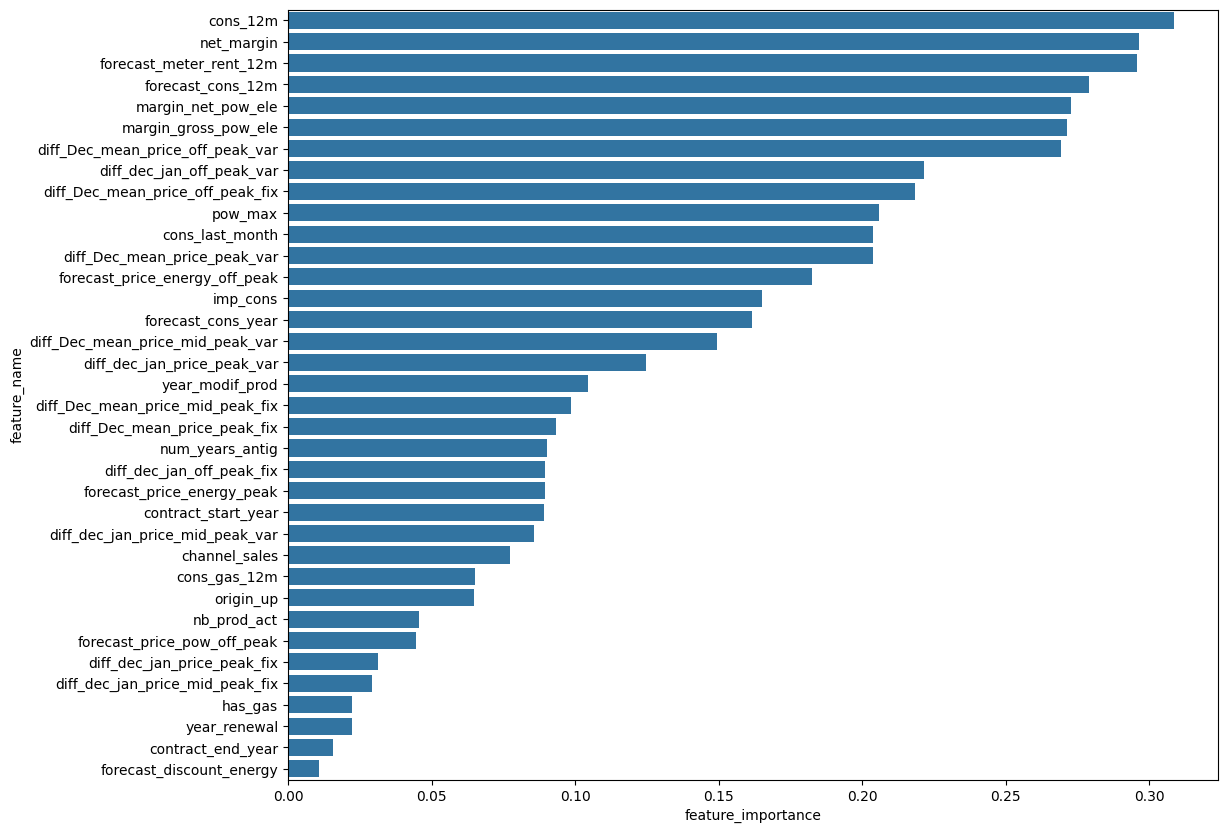

In [87]:
fig = plt.figure(figsize=(12,10))
ax = sns.barplot(data=feature_importance_df.sort_values(by=['feature_importance'], ascending=False), y='feature_name', x='feature_importance')

<font size="3"> The below table shows the main classification metrics.

In [88]:
print(classification_report(y, pred_y))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13187
           1       0.79      0.03      0.05      1419

    accuracy                           0.90     14606
   macro avg       0.85      0.51      0.50     14606
weighted avg       0.89      0.90      0.86     14606



<font size="3"> The below figure shows the confusion matrix.

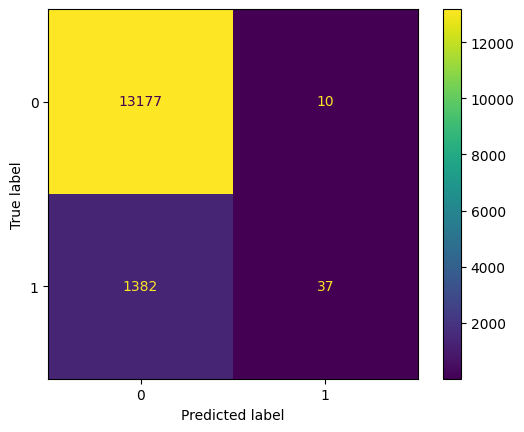

In [89]:
cm = confusion_matrix(y, pred_y, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

<font size="3"> **Based on the results above, we can see the performance is very bad. Although the accuracy is up to 90%, it is misleading and pointless, as we only focus on correctly predicting the positive class rather than the nagetive class. The model can only find out 6% of real positive samples. But luckily, in the predicted positive samples, up to 86% of them are real positive samples.** 